# Q-Reply @ Qhack 2021

Scope of the project is to develop a variational classifier to answer the following:
* Do we find a quantum advantage (higher accuracy) on some real-life dataset (no artificially generated data)?
* Are we happy already today with the fidelity of gates or do we need to wait years also for variational approaches? In other words, does the run on quantum hardware resembles the run on simulator? Does noise lead to worse or completely different solutions?

The data we use is taken from:<br>
CINAR, I. and KOKLU, M., (2019). “Classification of Rice Varieties Using Artificial Intelligence Methods.” International Journal of Intelligent Systems and Applications in Engineering, 7(3), 188-194.<br>
DOI: https://doi.org/10.18201/ijisae.2019355381

# Let's look at the data

The dataset contains 7 numerical features for 2 different types of rice grains ("Cammeo" and "Osmancik").

For visualization purposes and for making some initial experiments, we reduce the number of features to 2 using Principal Component Analysis (https://en.wikipedia.org/wiki/Principal_component_analysis).

We plot the dataset below.

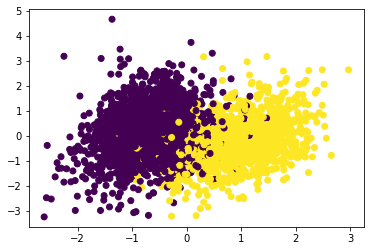

In [2]:
import data_loader as dl
import matplotlib.pyplot as plt

n_components = 2
pca_train_df, pca_test_df = dl.load_train_test_pca(n_components)
plt.scatter(
    x=pca_train_df["pca_1"],
    y=pca_train_df["pca_2"],
    c=pca_train_df["label"]
)
plt.show()

Even when only using only 2 principal components, the separation between the two classes is evident. Classification with classical methods (using all 7 features) reaches an accuracy of over 90%.

# How good can a variational quantum classifier perform?

We train circuit as following

* The 2 features are encoded in 2 qubits using the BasicEntanglerLayers
* StornglyEntanglingLayers are used with variational parameters that are learned
* The expectation value of PauliZ is measured on the first qubit
* The measurement value is rescaled to the range \[0, 1\] to match the labels
* A loss is introduced to compare the circuit output to the labels

# Effects on the performance

The following elements greatly affect the result of the circuit

* Operations in the circuit (e.g. only X rotations don't introduce much entanglement)
* Postprocessing and loss function (e.g. linear transformation + squareloss; sigmoid + logloss)
* Feature scaling (this affect the periodicity of the decision boundaries)